In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve
)

import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
df = pd.read_csv("data/processed/loan_master_final.csv")

print("Dataset shape:", df.shape)
df.head()


Dataset shape: (100000, 26)


,purpose,isjointapplication,loanamount,interestrate,monthlypayment,grade,residentialstate,homeownership,annualincome,incomeverified,...,revolvingutilizationrate,numderogatoryrec,numdelinquency2years,numchargeoff1year,numinquiries6mon,loan_year,loan_month,loan_dayofweek,term_months,default_flag
0,debtconsolidation,0.0,25190.0,6.25,490,E3,NM,rent,56471,1,...,49.02,0,19,10,0,2014,12,2,60.0,0
1,debtconsolidation,0.0,21189.0,10.49,455,B3,WA,rent,55038,0,...,72.40,1,0,0,0,2014,9,0,60.0,0
2,debtconsolidation,0.0,29908.0,9.11,622,B2,MS,rent,56610,1,...,66.27,0,1,1,0,2014,9,3,60.0,0
3,homeimprovement,0.0,13053.0,11.89,343,B3,TX,own,54887,1,...,61.05,1,0,0,3,2016,4,4,48.0,0
4,debtconsolidation,0.0,24613.0,15.13,587,A3,MA,rent,53522,1,...,56.39,2,14,7,1,2016,2,2,60.0,0


In [3]:
X = df.drop(columns=["default_flag"])
y = df["default_flag"]

print("Target distribution:")
print(y.value_counts())


Target distribution:
default_flag
0    89996
1    10004
Name: count, dtype: int64


In [16]:
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object"]).columns.tolist()

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)


Numeric features: ['isjointapplication', 'loanamount', 'interestrate', 'monthlypayment', 'annualincome', 'incomeverified', 'dtiratio', 'lengthcredithistory', 'numtotalcreditlines', 'numopencreditlines', 'numopencreditlines1year', 'revolvingbalance', 'revolvingutilizationrate', 'numderogatoryrec', 'numdelinquency2years', 'numchargeoff1year', 'numinquiries6mon', 'loan_year', 'loan_month', 'loan_dayofweek', 'term_months']
Categorical features: ['purpose', 'grade', 'residentialstate', 'homeownership']


In [17]:
from sklearn.preprocessing import RobustScaler


In [18]:
numeric_transformer = Pipeline(steps=[
    ("scaler", RobustScaler())
])

categorical_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)


In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)


Train size: (70000, 25)
Test size: (30000, 25)


In [20]:
y_train.value_counts()

default_flag
0    62997
1     7003
Name: count, dtype: int64

In [21]:
y_test.value_counts()

default_flag
0    26999
1     3001
Name: count, dtype: int64

In [22]:
model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        solver="lbfgs"
    ))
])


In [23]:
model.fit(X_train, y_train)
print("Baseline Logistic Regression model trained.")


Baseline Logistic Regression model trained.


In [24]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]


In [25]:
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("ROC-AUC Score:")
print(roc_auc_score(y_test, y_prob))


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.84      0.90     26999
           1       0.36      0.82      0.51      3001

    accuracy                           0.84     30000
   macro avg       0.67      0.83      0.70     30000
weighted avg       0.92      0.84      0.86     30000

ROC-AUC Score:
0.9149362153798408


In [26]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, classification_report
)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))


Accuracy: 0.8384333333333334
Precision: 0.36414483367677364
Recall: 0.8243918693768744
F1 Score: 0.5051556916794283

Classification Report:

              precision    recall  f1-score   support

           0       0.98      0.84      0.90     26999
           1       0.36      0.82      0.51      3001

    accuracy                           0.84     30000
   macro avg       0.67      0.83      0.70     30000
weighted avg       0.92      0.84      0.86     30000



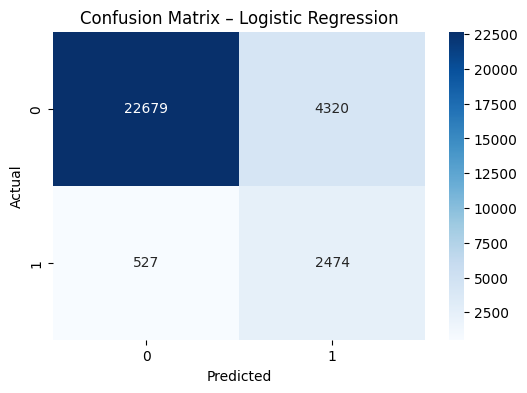

In [28]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – Logistic Regression")
plt.show()


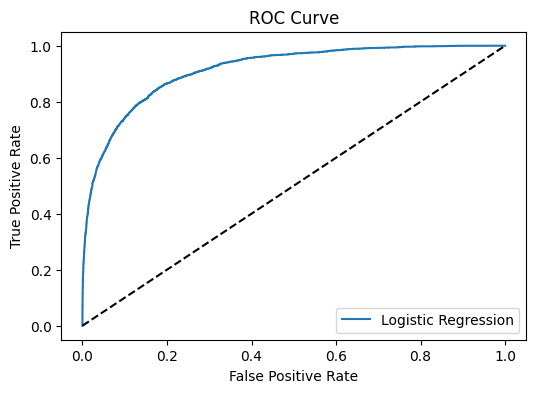

In [15]:
fpr, tpr, _ = roc_curve(y_test, y_prob)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label="Logistic Regression")
plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


In [29]:
import joblib
import os

os.makedirs("models", exist_ok=True)

joblib.dump(model, "models/credit_risk_model_logistic_regression.pkl")
print("✅ Model saved as credit_risk_model_logistic_regression.pkl")

✅ Model saved as credit_risk_model_logistic_regression.pkl


In [30]:
import joblib

model = joblib.load("models/credit_risk_model_logistic_regression.pkl")
print("✅ Model loaded successfully")



✅ Model loaded successfully


In [31]:
import pandas as pd

# Sample test input (must match training features)
test_data = {
    "purpose": "debtconsolidation",
    "isjointapplication": 0,
    "loanamount": 25000,
    "interestrate": 12.5,
    "monthlypayment": 550,
    "grade": "B3",
    "residentialstate": "CA",
    "homeownership": "RENT",
    "annualincome": 65000,
    "incomeverified": 1,
    "dtiratio": 18.5,
    "lengthcredithistory": 10,
    "numtotalcreditlines": 12,
    "numopencreditlines": 8,
    "numopencreditlines1year": 2,
    "revolvingbalance": 12000,
    "revolvingutilizationrate": 55.0,
    "numderogatoryrec": 0,
    "numdelinquency2years": 1,
    "numchargeoff1year": 0,
    "numinquiries6mon": 2,
    "loan_year": 2019,
    "loan_month": 6,
    "loan_dayofweek": 2,
    "term_months": 60
}

df_test = pd.DataFrame([test_data])

# Predict probability
prob_default = model.predict_proba(df_test)[0][1]

# Predict class
prediction = model.predict(df_test)[0]

print("Probability of Default:", round(prob_default, 3))
print("Prediction:", "DEFAULT" if prediction == 1 else "NON-DEFAULT")


Probability of Default: 0.017
Prediction: NON-DEFAULT


In [32]:
def risk_bucket(prob):
    if prob >= 0.7:
        return "HIGH RISK"
    elif prob >= 0.4:
        return "MEDIUM RISK"
    else:
        return "LOW RISK"

bucket = risk_bucket(prob_default)

print("Risk Category:", bucket)


Risk Category: LOW RISK


In [33]:
from sklearn.model_selection import StratifiedKFold, cross_val_score


In [34]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_auc_scores = cross_val_score(
    model,
    X,
    y,
    cv=skf,
    scoring='roc_auc',
    n_jobs=-1
)

print("AUC scores for each fold:", cv_auc_scores)
print("Mean AUC:", cv_auc_scores.mean())
print("Std Dev:", cv_auc_scores.std())


AUC scores for each fold: [0.91441181 0.91076427 0.91889574 0.91849461 0.91310614]
Mean AUC: 0.9151345138280188
Std Dev: 0.003136006825819258


In [36]:
model_metadata = {
    "model_type": "Logistic Regression",
    "cv_mean_auc": cv_auc_scores.mean(),
    "cv_std_auc": cv_auc_scores.std(),
    "features_count": X.shape[1],
    "target": "default_flag"
}

joblib.dump(model_metadata, "models/model_metadata.pkl")


['models/model_metadata.pkl']